# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

pd.set_option('display.max_columns',None)

---
## 2. Load data

In [ ]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [ ]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year
0,0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,0,0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016
1,1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016
2,2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [ ]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [ ]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [ ]:
train_data = df.merge(diff, on ='id', how='left')

In [ ]:
train_data = train_data.drop('Unnamed: 0', axis=1)

In [ ]:
train_data.head(10)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,0,0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,2,13.200,0,2010,2016,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,2010-01-13,2016-07-03,2010-01-13,2015-09-03,445.75,526,0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,2,19.800,0,2010,2016,-0.006192,0.162916
5,1aa498825382410b098937d65c4ec26d,7,8302,0,1998,2011-09-12,2016-09-12,2015-01-11,2015-10-12,796.94,1998,0,30.12,0.164775,0.086131,45.308378,f,181.21,33.12,33.12,1,118.89,4,4,13.200,1,2011,2016,-0.008087,-0.000001
6,7ab4bf4878d8f7661dfc20e9b8e18011,4,45097,0,0,2011-02-12,2016-02-12,2011-02-12,2015-03-12,8069.28,0,0,0.00,0.166178,0.087538,44.311378,f,0.00,4.04,4.04,1,346.63,4,4,15.000,1,2011,2016,-0.004628,0.000000
7,01495c955be7ec5e7f3203406785aae0,4,29552,0,1260,2010-04-21,2016-04-21,2010-04-21,2015-04-22,864.73,751,0,144.49,0.115174,0.098837,40.606701,f,70.63,53.92,53.92,1,100.09,6,4,26.400,0,2010,2016,-0.007801,0.162916
8,f53a254b1115634330c12c7fdbf7958a,7,2962,0,0,2011-09-23,2016-09-23,2011-09-23,2015-09-25,444.38,0,0,15.85,0.145711,0.000000,44.311378,f,0.00,12.82,12.82,1,42.59,4,2,13.200,0,2011,2016,-0.003767,0.177779
9,10c1b2f97a2d2a6f10299dc213d1a370,5,26064,0,2188,2010-04-05,2016-04-05,2015-04-29,2015-05-05,2738.10,2188,0,130.43,0.115761,0.099419,40.606701,f,219.59,33.42,33.42,1,329.60,6,4,31.500,0,2010,2016,-0.007137,0.000000


In [ ]:
#label encoding the has_gas column

from sklearn.preprocessing import LabelEncoder
gas_encoder = LabelEncoder()
train_data['has_gas'] = gas_encoder.fit_transform(train_data['has_gas'])

In [ ]:
train_data['tenure']= train_data['contract_end_year'] - train_data['contract_start_year']

In [ ]:
def plot_stacked_bar_with_percent_label_by_churn(df, target_variable, if_sort=False, figsize=(20,6)):
    plot_data = df.groupby([target_variable,'churn']).size().reset_index(name='count')
    plot_data = plot_data.pivot(index=target_variable, columns='churn', values='count').fillna(0)
    plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)
    if if_sort:
        plot_data = plot_data.sort_values(by=[0])
    ax = plot_data.plot(kind='bar', rot=False, stacked=True, figsize=figsize)
    plt.legend(['stayed', 'churned'], loc='upper center', ncol=2)
    # add label
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height()*100)
        if percentage!='0.0%':
            x = p.get_x() + p.get_width()/2
            y = 1 - p.get_height()/1.8
            ax.annotate(s=percentage, xy=(x, y), ha='center')
    ax.margins(y=0.1)

In [ ]:
# drop useless columns
train_data['year_modif_prod'] = train_data['date_modif_prod'].dt.year
train_data['year_renewal'] = train_data['date_renewal'].dt.year
train_data = train_data.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'])

In [ ]:
numerical_features = [feature for feature in train_data.columns if train_data[feature].dtype != 'O']
discrete_features = [feature for feature in train_data.columns if len(train_data[feature].unique())<=15]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features +['id']]

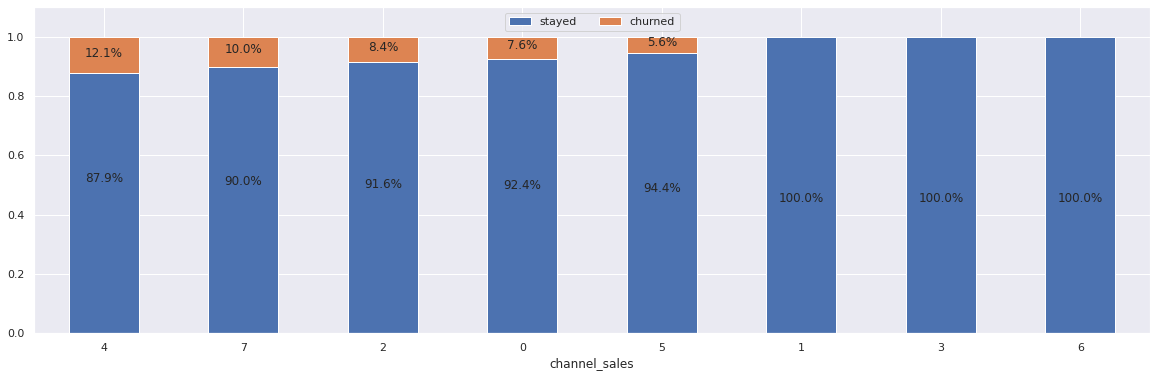

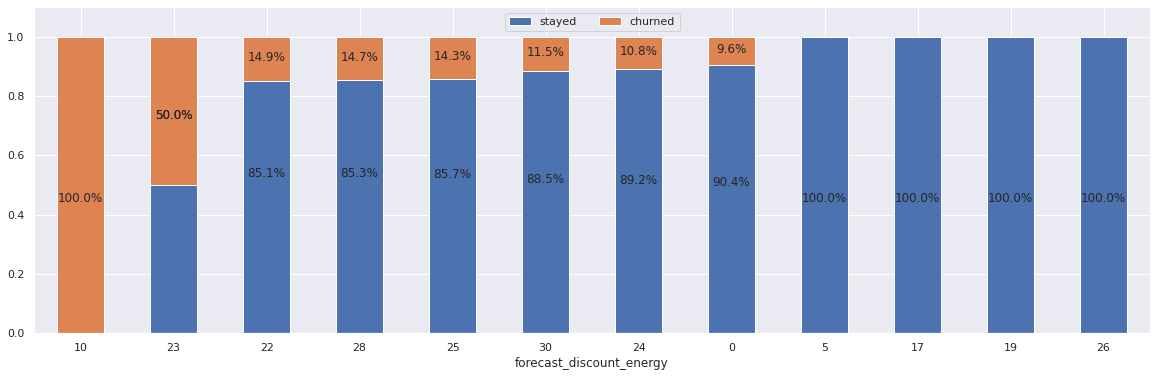

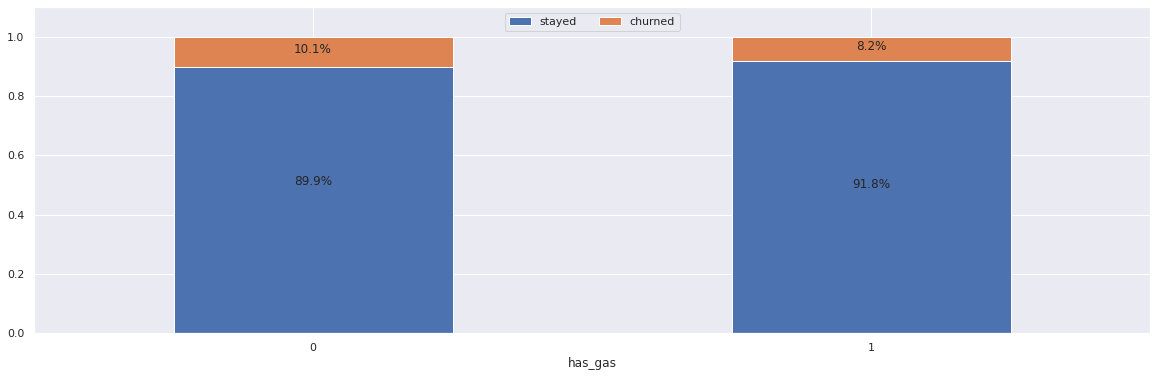

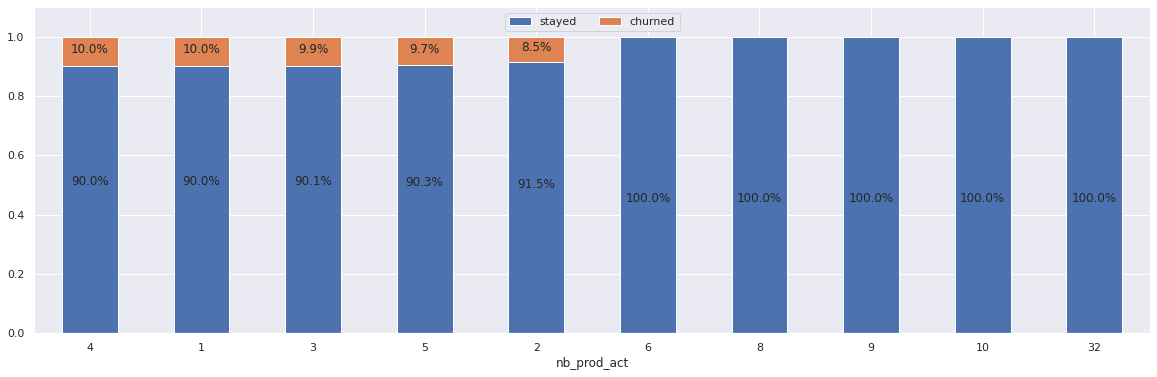

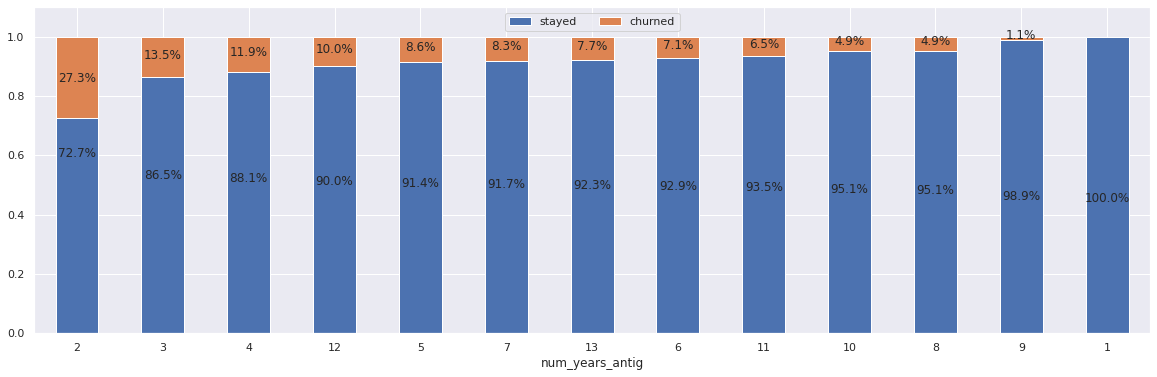

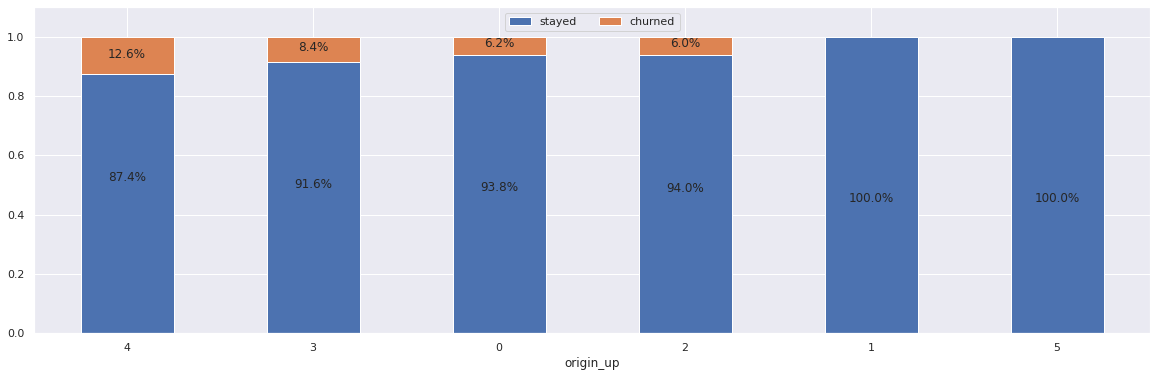

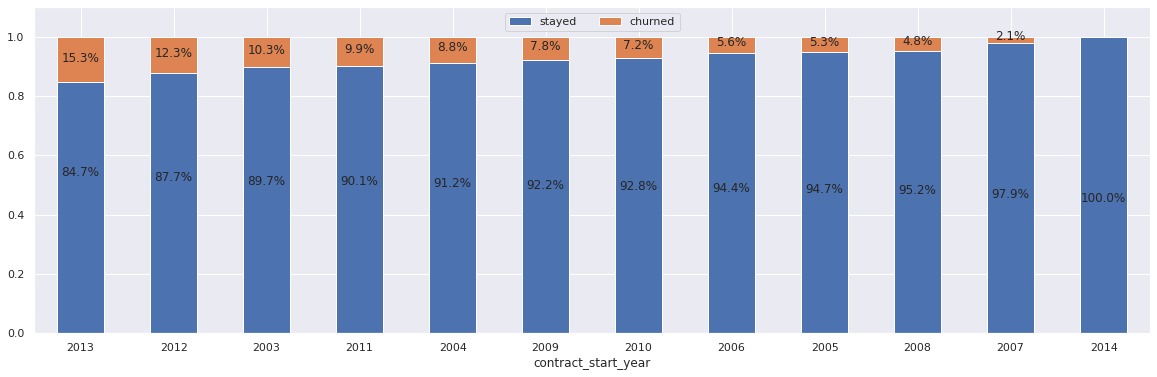

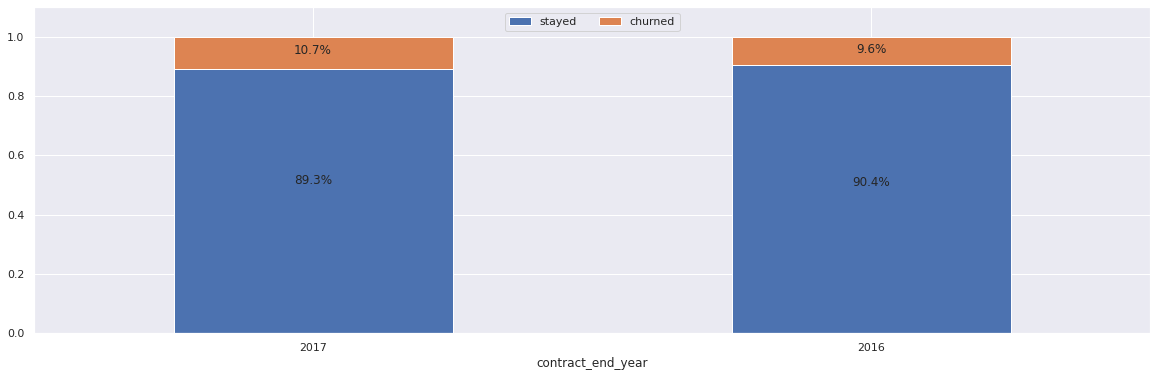

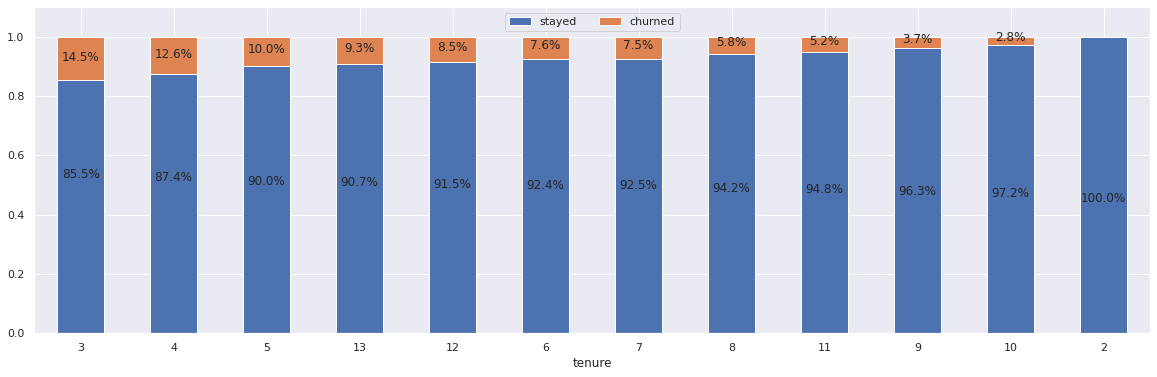

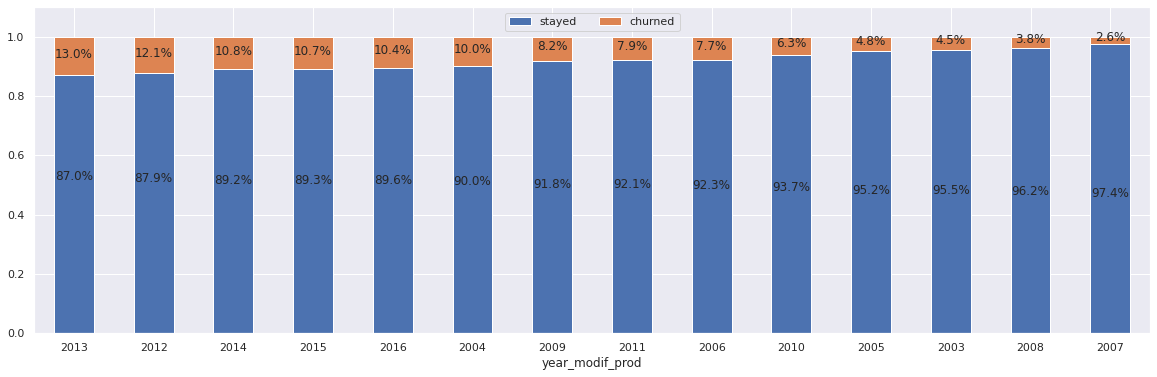

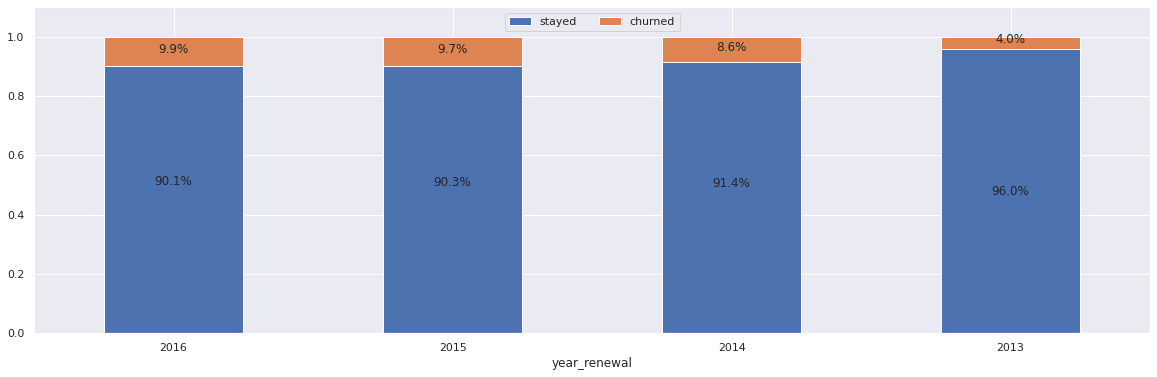

In [ ]:
for feature in discrete_features:
  if feature != 'churn':
    # plt.scatter( train_data[feature],train_data['churn'])
    # plt.title(feature)
    # plt.show()
    plot_stacked_bar_with_percent_label_by_churn(train_data, feature, True)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
train_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_start_year,contract_end_year,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,tenure,year_modif_prod,year_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,4,43.648,1,2013,2016,0.020057,3.700961,3,2015,2015
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,2,13.800,0,2009,2016,-0.003767,0.177779,7,2009,2015
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,47.96,0,0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,2,13.856,0,2010,2016,-0.004670,0.177779,6,2010,2015
3,bba03439a292a1e166f80264c16191cb,5,1584,0,0,240.04,0,0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,2,13.200,0,2010,2016,-0.004547,0.177779,6,2010,2015
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,445.75,526,0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,2,19.800,0,2010,2016,-0.006192,0.162916,6,2010,2015


**SubTask 2**

In [ ]:
X = train_data.drop(columns=['id','churn'])
y = train_data['churn']
X.shape, y.shape

((14606, 27), (14606,))

Fold 1 Precision 0.933 Recall 0.049 Accuracy 0.907


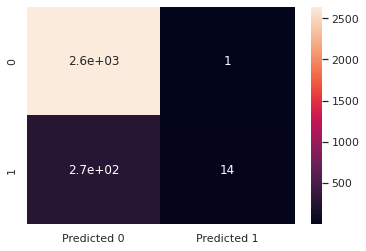

Fold 2 Precision 0.714 Recall 0.035 Accuracy 0.905


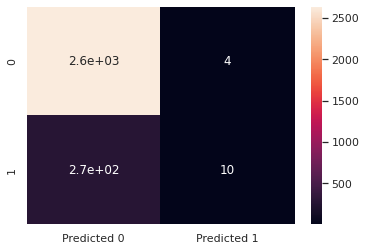

Fold 3 Precision 0.947 Recall 0.063 Accuracy 0.909


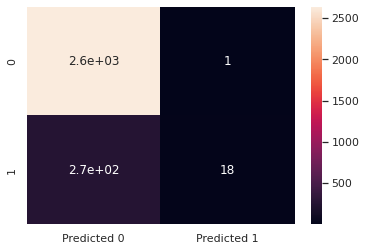

Fold 4 Precision 0.684 Recall 0.046 Accuracy 0.905


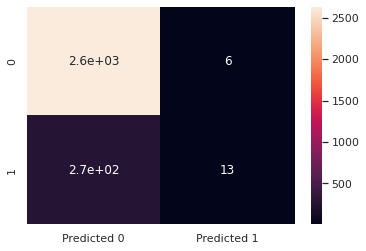

Fold 5 Precision 1.000 Recall 0.053 Accuracy 0.908


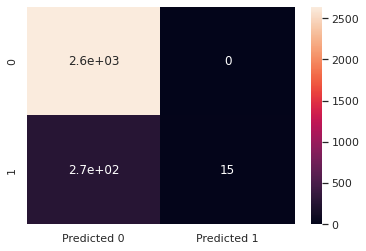

Total  Precision 0.854 Recall 0.049 Accuracy 0.907


In [ ]:
# 
import numpy as np
pred_train_labels = np.zeros(shape=(X.shape[0], 2))   # pred training labels
feature_importance_df = pd.DataFrame(data={'feature_name':X.columns, 'feature_importance':[0]*len(X.columns)})
# create cv dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # build model
    rf = RandomForestClassifier(random_state=56)
    # train model
    rf.fit(X_train, y_train)
    pred_train_labels[test_index] = rf.predict_proba(X_test)
    feature_importance_df['feature_importance'] = feature_importance_df['feature_importance'] + (rf.feature_importances_)
    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} Recall {recall_score(y_test, rf.predict(X_test)):.3f} Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter = fold_counter + 1
    matrix = confusion_matrix(y_test, rf.predict(X_test), labels=[0,1])
    df_cm = pd.DataFrame(matrix, index=[i for i in ['0','1']], columns =[i for i in ['Predicted 0','Predicted 1']])
    # print(matrix)
    sns.heatmap(df_cm,annot=True)
    plt.show()
# predicted labels
pred_y = pred_train_labels.argmax(axis=-1)
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Kfold cross validation strategy is used to evaluate the model's performace. But as dataset is imbalance so instead of giving import importance to accuracy I have given importance to precision and Recall.

From the above output it can be seen that model performance is very bad , although luckily it is prediction positive (not churned) records more correctly but there is really bad performance in predicting 1s

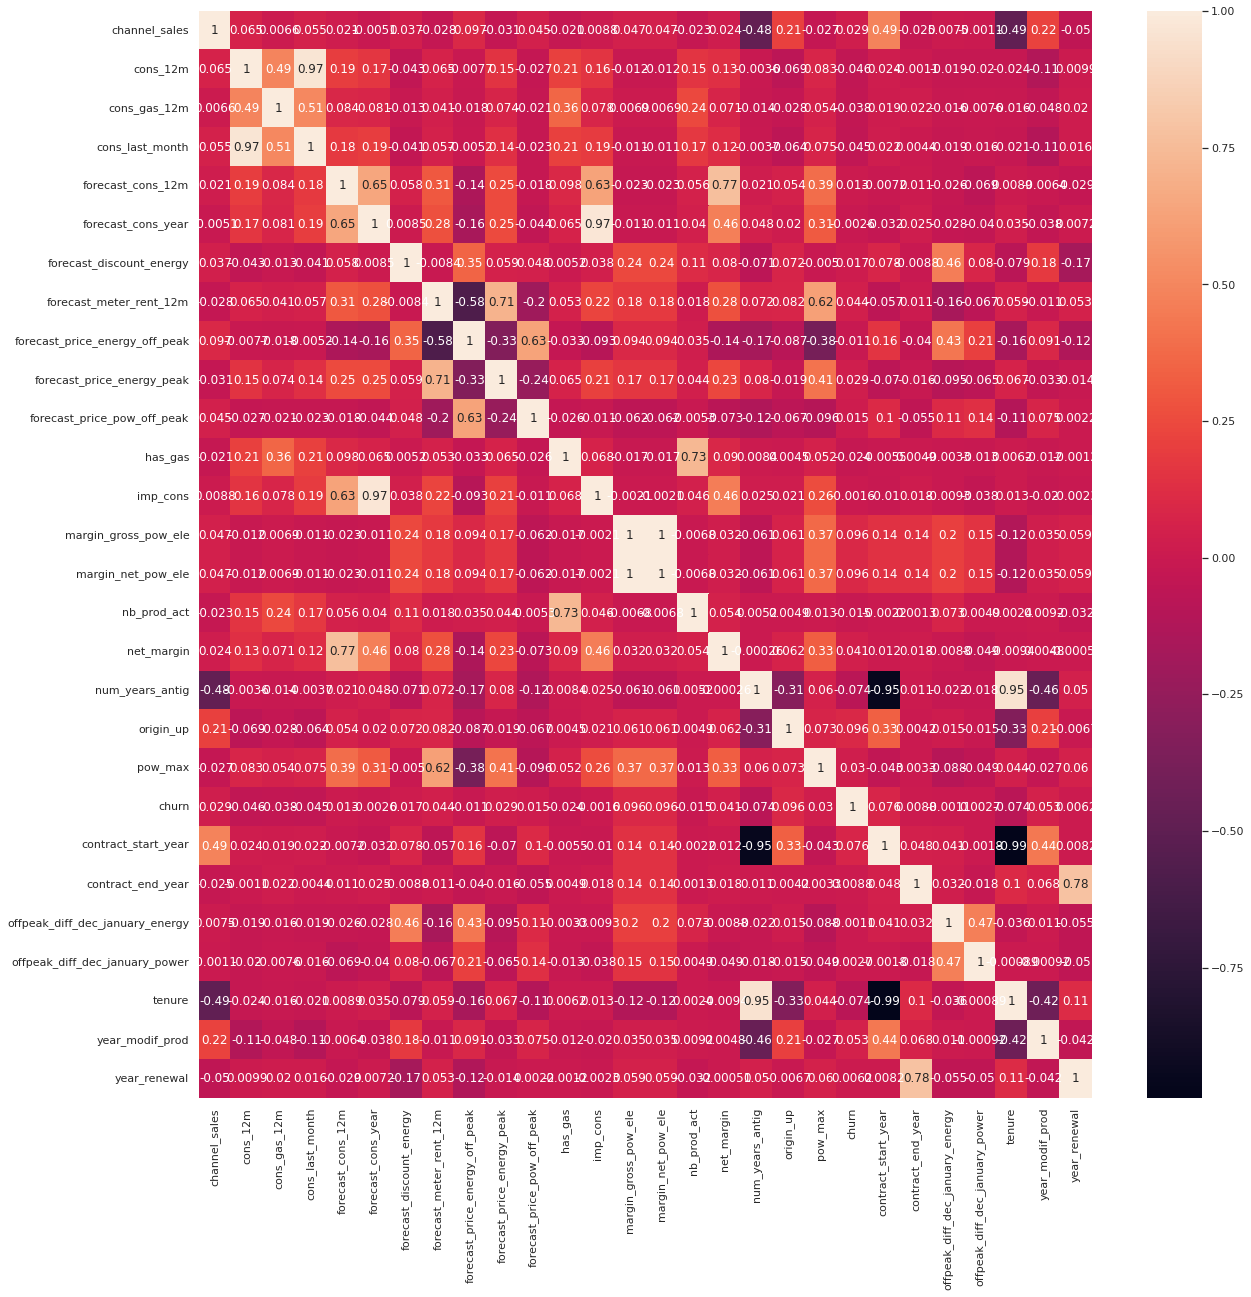

In [ ]:
# checking the multicolearity

plt.figure(figsize= (20,20))
sns.heatmap(train_data.corr(),annot=True)
plt.show()

In [ ]:
# removing highly colinear columns

train_data_new= train_data.drop(columns=['cons_12m','forecast_meter_rent_12m','imp_cons','margin_net_pow_ele','num_years_antig','year_renewal'],axis=0)

In [ ]:
X = train_data_new.drop(columns=['id','churn'])
y = train_data_new['churn']
X.shape, y.shape

((14606, 21), (14606,))

In [ ]:
train_data_new.churn.value_counts()

,id,channel_sales,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,nb_prod_act,net_margin,origin_up,pow_max,churn,contract_start_year,contract_end_year,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,tenure,year_modif_prod
0,24011ae4ebbe3035111d65fa7c15bc57,4,54946,0,0.00,0,0,0.114481,0.098142,40.606701,1,25.44,2,678.99,4,43.648,1,2013,2016,0.020057,3.700961,3,2015
1,d29c2c54acc38ff3c0614d0a653813dd,0,0,0,189.95,0,0,0.145711,0.000000,44.311378,0,16.38,1,18.89,2,13.800,0,2009,2016,-0.003767,0.177779,7,2009
2,764c75f661154dac3a6c254cd082ea7d,4,0,0,47.96,0,0,0.165794,0.087899,44.311378,0,28.60,1,6.60,2,13.856,0,2010,2016,-0.004670,0.177779,6,2010
3,bba03439a292a1e166f80264c16191cb,5,0,0,240.04,0,0,0.146694,0.000000,44.311378,0,30.22,1,25.46,2,13.200,0,2010,2016,-0.004547,0.177779,6,2010
4,149d57cf92fc41cf94415803a877cb4b,0,0,526,445.75,526,0,0.116900,0.100015,40.606701,0,44.91,1,47.98,2,19.800,0,2010,2016,-0.006192,0.162916,6,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,c603db70dd55094ecc03b1980d96107c,4,0,3838,3377.13,3838,0,0.115174,0.098837,40.606701,0,21.00,1,377.16,4,19.800,1,2011,2016,-0.007137,0.000000,5,2014
10260,eb005baed443eef421f0278a747c87dd,0,0,186086,3310.19,12,0,0.113323,0.096984,40.606701,0,17.79,2,509.30,3,16.780,1,2009,2016,-0.008502,0.162916,7,2009
12740,941b1ee274294f2c43dd3cf3ca5c034d,0,0,10525,10102.52,10525,0,0.112922,0.097810,40.606701,0,19.57,1,802.10,3,21.900,1,2004,2016,-0.012153,0.000000,12,2014
12196,35b2497885b429034b74e89789371626,2,0,0,1986.08,0,0,0.115360,0.100243,40.606701,0,34.56,1,262.29,3,23.100,1,2010,2016,-0.012679,0.162916,6,2015


there is large difference between number of not churned and churned records, to make the data balance, I will upsample the churned records

In [ ]:
from sklearn.utils import resample
less_value_data= train_data_new[train_data_new['churn']==1]
resampled_data= resample(less_value_data, replace=True, n_samples=10000, random_state=1)
Frame = [train_data_new,resampled_data]
train_data_new= pd.concat(Frame,axis=0,ignore_index=True)

In [ ]:
X = train_data_new.drop(columns=['id','churn'])
testing_set = train_data_new.drop(columns=['id','churn'])
y = train_data_new['churn']
X.shape, y.shape

((24606, 21), (24606,))

In [ ]:
# 
import numpy as np
pred_train_labels = np.zeros(shape=(X.shape[0], 2))   # pred training labels
pred_test_labels = np.zeros(shape=(testing_set.shape[0], 2))   # pred training labels
feature_importance_df = pd.DataFrame(data={'feature_name':X.columns, 'feature_importance':[0]*len(X.columns)})
# create cv dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    # print(test_index,train_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # build model
    rf = RandomForestClassifier(random_state=56)
    # train model
    rf.fit(X_train, y_train)
    pred_train_labels[test_index] = rf.predict_proba(X_test)
    pred_test_labels += rf.predict_proba(testing_set)/5
    feature_importance_df['feature_importance'] = feature_importance_df['feature_importance'] + (rf.feature_importances_)
    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} Recall {recall_score(y_test, rf.predict(X_test)):.3f} Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter = fold_counter + 1
    matrix = confusion_matrix(y_test, rf.predict(X_test), labels=[0,1])
    df_cm = pd.DataFrame(matrix, index=[i for i in ['0','1']], columns =[i for i in ['Predicted 0','Predicted 1']])
    # print(matrix)
    # sns.heatmap(df_cm,annot=True)
    plt.show()
# predicted labels
pred_y = pred_train_labels.argmax(axis=-1)
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.981 Recall 0.999 Accuracy 0.991
Fold 2 Precision 0.984 Recall 0.994 Accuracy 0.990
Fold 3 Precision 0.982 Recall 0.999 Accuracy 0.991
Fold 4 Precision 0.980 Recall 1.000 Accuracy 0.991
Fold 5 Precision 0.984 Recall 0.997 Accuracy 0.991
Total  Precision 0.982 Recall 0.998 Accuracy 0.991


with upsampling the recall is improved and hence the model performance

In [ ]:
train_data_new

,id,channel_sales,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,nb_prod_act,net_margin,origin_up,pow_max,churn,contract_start_year,contract_end_year,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,tenure,year_modif_prod
0,24011ae4ebbe3035111d65fa7c15bc57,4,54946,0,0.00,0,0,0.114481,0.098142,40.606701,1,25.44,2,678.99,4,43.648,1,2013,2016,0.020057,3.700961,3,2015
1,d29c2c54acc38ff3c0614d0a653813dd,0,0,0,189.95,0,0,0.145711,0.000000,44.311378,0,16.38,1,18.89,2,13.800,0,2009,2016,-0.003767,0.177779,7,2009
2,764c75f661154dac3a6c254cd082ea7d,4,0,0,47.96,0,0,0.165794,0.087899,44.311378,0,28.60,1,6.60,2,13.856,0,2010,2016,-0.004670,0.177779,6,2010
3,bba03439a292a1e166f80264c16191cb,5,0,0,240.04,0,0,0.146694,0.000000,44.311378,0,30.22,1,25.46,2,13.200,0,2010,2016,-0.004547,0.177779,6,2010
4,149d57cf92fc41cf94415803a877cb4b,0,0,526,445.75,526,0,0.116900,0.100015,40.606701,0,44.91,1,47.98,2,19.800,0,2010,2016,-0.006192,0.162916,6,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24601,c603db70dd55094ecc03b1980d96107c,4,0,3838,3377.13,3838,0,0.115174,0.098837,40.606701,0,21.00,1,377.16,4,19.800,1,2011,2016,-0.007137,0.000000,5,2014
24602,eb005baed443eef421f0278a747c87dd,0,0,186086,3310.19,12,0,0.113323,0.096984,40.606701,0,17.79,2,509.30,3,16.780,1,2009,2016,-0.008502,0.162916,7,2009
24603,941b1ee274294f2c43dd3cf3ca5c034d,0,0,10525,10102.52,10525,0,0.112922,0.097810,40.606701,0,19.57,1,802.10,3,21.900,1,2004,2016,-0.012153,0.000000,12,2014
24604,35b2497885b429034b74e89789371626,2,0,0,1986.08,0,0,0.115360,0.100243,40.606701,0,34.56,1,262.29,3,23.100,1,2010,2016,-0.012679,0.162916,6,2015


Bonus: If the discount has been provided to customers will the probability of churn reduces

In [ ]:
prob_no_discount = pd.DataFrame(data = pred_train_labels, columns=['0', '1'])
prob_no_discount['id'] = train_data['id']
prob_no_discount = prob_no_discount[['id','0','1']]
prob_no_discount=prob_no_discount.dropna()
prob_no_discount

,id,0,1
0,24011ae4ebbe3035111d65fa7c15bc57,0.01,0.99
1,d29c2c54acc38ff3c0614d0a653813dd,0.90,0.10
2,764c75f661154dac3a6c254cd082ea7d,0.93,0.07
3,bba03439a292a1e166f80264c16191cb,0.92,0.08
4,149d57cf92fc41cf94415803a877cb4b,0.89,0.11
...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,0.76,0.24
14602,d0a6f71671571ed83b2645d23af6de00,0.00,1.00
14603,10e6828ddd62cbcf687cb74928c4c2d2,0.00,1.00
14604,1cf20fd6206d7678d5bcafd28c53b4db,0.86,0.14


to predcit the probability of churn when applying a 20%

In [ ]:
prob_discount = pd.DataFrame(data=pred_test_labels, columns=['0_dis','1_dis'])
customer_prob = prob_no_discount.join(prob_discount)
customer_prob

,id,0,1,0_dis,1_dis
0,24011ae4ebbe3035111d65fa7c15bc57,0.01,0.99,0.004,0.996
1,d29c2c54acc38ff3c0614d0a653813dd,0.90,0.10,0.942,0.058
2,764c75f661154dac3a6c254cd082ea7d,0.93,0.07,0.948,0.052
3,bba03439a292a1e166f80264c16191cb,0.92,0.08,0.958,0.042
4,149d57cf92fc41cf94415803a877cb4b,0.89,0.11,0.968,0.032
...,...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,0.76,0.24,0.886,0.114
14602,d0a6f71671571ed83b2645d23af6de00,0.00,1.00,0.000,1.000
14603,10e6828ddd62cbcf687cb74928c4c2d2,0.00,1.00,0.000,1.000
14604,1cf20fd6206d7678d5bcafd28c53b4db,0.86,0.14,0.934,0.066


In [ ]:
gas_off_peak  = price_df.groupby('id').agg({'price_off_peak_var': ['mean']})
  

power_off_peak  = price_df.groupby('id').agg({'price_off_peak_fix': ['mean']})

In [ ]:
mean_prices_off_peak=power_off_peak.join(gas_off_peak, on='id', how='left')
mean_prices_off_peak['id']=mean_prices_off_peak.index
mean_prices_off_peak.columns=['price_off_peak_var_mean','price_off_peak_fix_mean','id']
mean_prices_off_peak

,price_off_peak_var_mean,price_off_peak_fix_mean,id
id,,,
0002203ffbb812588b632b9e628cc38d,40.701732,0.124338,0002203ffbb812588b632b9e628cc38d
0004351ebdd665e6ee664792efc4fd13,44.385450,0.146426,0004351ebdd665e6ee664792efc4fd13
0010bcc39e42b3c2131ed2ce55246e3c,45.319710,0.181558,0010bcc39e42b3c2131ed2ce55246e3c
0010ee3855fdea87602a5b7aba8e42de,40.647427,0.118757,0010ee3855fdea87602a5b7aba8e42de
00114d74e963e47177db89bc70108537,44.266930,0.147926,00114d74e963e47177db89bc70108537
...,...,...,...
ffef185810e44254c3a4c6395e6b4d8a,40.896427,0.138863,ffef185810e44254c3a4c6395e6b4d8a
fffac626da707b1b5ab11e8431a4d0a2,44.311375,0.147137,fffac626da707b1b5ab11e8431a4d0a2
fffc0cacd305dd51f316424bbb08d1bd,41.160171,0.153879,fffc0cacd305dd51f316424bbb08d1bd


In [ ]:
# calculate expected profit of a single customer with discounted prices and without discounted prices
def expect_from_a_customer(customer_id):
    # expected values without discount
    average_yearly_price_gas = mean_prices_off_peak[mean_prices_off_peak['id']==customer_id]['price_off_peak_var_mean'].values[0]
    total_yearly_usage_gas = train_data[train_data['id']==customer_id]['cons_12m'].values[0]
    average_yearly_price_pow = mean_prices_off_peak[mean_prices_off_peak['id']==customer_id]['price_off_peak_fix_mean'].values[0]
    total_yearly_usage_pow = train_data[train_data['id']==customer_id]['cons_gas_12m'].values[0]
    total_profit = average_yearly_price_pow*total_yearly_usage_pow + average_yearly_price_gas*total_yearly_usage_gas
    # 
    prob_stay = customer_prob[customer_prob['id']==customer_id]['0'].values[0]
    expected_profit = prob_stay*total_profit
    # expected values with discount
    total_profit_dis = total_profit*0.8
    # 
    prob_stay_dis = customer_prob[customer_prob['id']==customer_id]['0_dis'].values[0]
    expected_profit_dis = prob_stay_dis*total_profit_dis
    return expected_profit, expected_profit_dis

In [ ]:
# Calculate expected profit from each customer
expected_no_dis, expected_dis = [],[]
for cus_id in customer_prob['id']:
    temp = expect_from_a_customer(customer_id=cus_id)
    expected_no_dis.append(temp[0])
    expected_dis.append(temp[1])
#
customer_prob['expected_no_dis'] = expected_no_dis
customer_prob['expected_dis'] = expected_dis
customer_prob['diff_discount'] = customer_prob['expected_dis'] - customer_prob['expected_no_dis']
customer_prob

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
0,24011ae4ebbe3035111d65fa7c15bc57,0.01,0.99,0.004,0.996,6.856551e+01,2.194096e+01,-46.624547
1,d29c2c54acc38ff3c0614d0a653813dd,0.90,0.10,0.942,0.058,1.858419e+05,1.556116e+05,-30230.283675
2,764c75f661154dac3a6c254cd082ea7d,0.93,0.07,0.948,0.052,2.245549e+04,1.831209e+04,-4143.399545
3,bba03439a292a1e166f80264c16191cb,0.92,0.08,0.958,0.042,6.470362e+04,5.390093e+04,-10802.691098
4,149d57cf92fc41cf94415803a877cb4b,0.89,0.11,0.968,0.032,1.602401e+05,1.394269e+05,-20813.212490
...,...,...,...,...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,0.76,0.24,0.886,0.114,1.093450e+06,1.019786e+06,-73663.986053
14602,d0a6f71671571ed83b2645d23af6de00,0.00,1.00,0.000,1.000,0.000000e+00,0.000000e+00,0.000000
14603,10e6828ddd62cbcf687cb74928c4c2d2,0.00,1.00,0.000,1.000,0.000000e+00,0.000000e+00,0.000000
14604,1cf20fd6206d7678d5bcafd28c53b4db,0.86,0.14,0.934,0.066,4.992120e+03,4.337339e+03,-654.780331


In [ ]:
customer_prob['has_stay_prob_increaed'] = (customer_prob['0_dis'] - customer_prob['0'])>0
customer_prob['has_stay_prob_incresedby0.5']= (customer_prob['0']<0.5) & (customer_prob['0_dis']>0.5)

In [ ]:
customer_prob[customer_prob['has_stay_prob_increaed'] & customer_prob['has_stay_prob_incresedby0.5']  & (customer_prob['diff_discount']>0) ]

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount,has_stay_prob_increaed,has_stay_prob_incresedby0.5
91,9d566b80c46439fb4fa5d9c8eaa51f7e,0.36,0.64,0.654,0.346,117343.014666,1.705385e+05,53195.499982,True,True
128,3c4ee938001975a4d07cf27a54de433c,0.49,0.51,0.758,0.242,782669.712628,9.685937e+05,185923.988877,True,True
229,56c94ad421f0b3ba7898412d082e9680,0.42,0.58,0.756,0.244,34941.989116,5.031646e+04,15374.475211,True,True
267,d997a45fc29f1c98891bcce4e25ba400,0.42,0.58,0.744,0.256,88112.881624,1.248685e+05,36755.659192,True,True
421,59470abf25e95d8334151956a6ed9bd2,0.46,0.54,0.740,0.260,978035.286107,1.258689e+06,280653.603839,True,True
...,...,...,...,...,...,...,...,...,...,...
14167,80bbffc993f4bac43c1918a6ba412add,0.21,0.79,0.614,0.386,24275.386348,5.678128e+04,32505.898291,True,True
14180,6818e72b1a84405c413f4ef068c9f993,0.42,0.58,0.714,0.286,345523.899088,4.699125e+05,124388.603672,True,True
14261,b6f89043de74c640b256969b9cb56090,0.46,0.54,0.766,0.234,197946.251900,2.636988e+05,65752.581066,True,True
14280,72dbf800bd00186845a8447f4503917f,0.38,0.62,0.704,0.296,164039.126708,2.431233e+05,79084.126350,True,True


There are 206 customer for which the probablity of stay and profit also increased after discount

In [ ]:
#Top 10 customers with maximum profit difference after discount
customer_prob[customer_prob['has_stay_prob_increaed'] & customer_prob['has_stay_prob_incresedby0.5']  & (customer_prob['diff_discount']>0) ].sort_values('diff_discount', ascending=False)[:10]

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount,has_stay_prob_increaed,has_stay_prob_incresedby0.5
12670,7b027a3b4fe4d8e09c51a6f718287582,0.27,0.73,0.620,0.380,1.163827e+07,2.137993e+07,9.741661e+06,True,True
1431,bc9de7bd8a721bf60db0c2e38734a4bc,0.36,0.64,0.668,0.332,8.736474e+06,1.296881e+07,4.232336e+06,True,True
5259,7f61432a298e150c5e06e1dec4692276,0.40,0.60,0.678,0.322,1.011830e+07,1.372041e+07,3.602114e+06,True,True
11396,b25b3f63ec641025671add0aa9dbfd7f,0.22,0.78,0.622,0.378,2.669299e+06,6.037468e+06,3.368170e+06,True,True
12102,148dfbebe4e3aeec9274aabba3ecf775,0.35,0.65,0.712,0.288,4.271266e+06,6.951180e+06,2.679914e+06,True,True
4040,746e6d63d641dd77729d6384a908f910,0.44,0.56,0.770,0.230,6.657769e+06,9.320877e+06,2.663108e+06,True,True
10971,651899daf1d837009495e29916446dc6,0.44,0.56,0.730,0.270,7.861329e+06,1.043413e+07,2.572799e+06,True,True
12005,6a7c470b379f2d161ce48d8bc9a9fbb8,0.25,0.75,0.644,0.356,1.331975e+06,2.744934e+06,1.412959e+06,True,True
5149,417dace351647edd8e8ade3b179fae88,0.38,0.62,0.706,0.294,2.483801e+06,3.691713e+06,1.207912e+06,True,True
9268,18acec34034500d84a888a1cc5a29d7a,0.29,0.71,0.666,0.334,1.365376e+06,2.508524e+06,1.143149e+06,True,True
